In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
from plot_lapimenoajat import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 100000")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogram of x and y coordinates

x mean:  1933.45561
y mean:  581.71249
x std:  874.0018203696877
y std:  1035.9577992022648


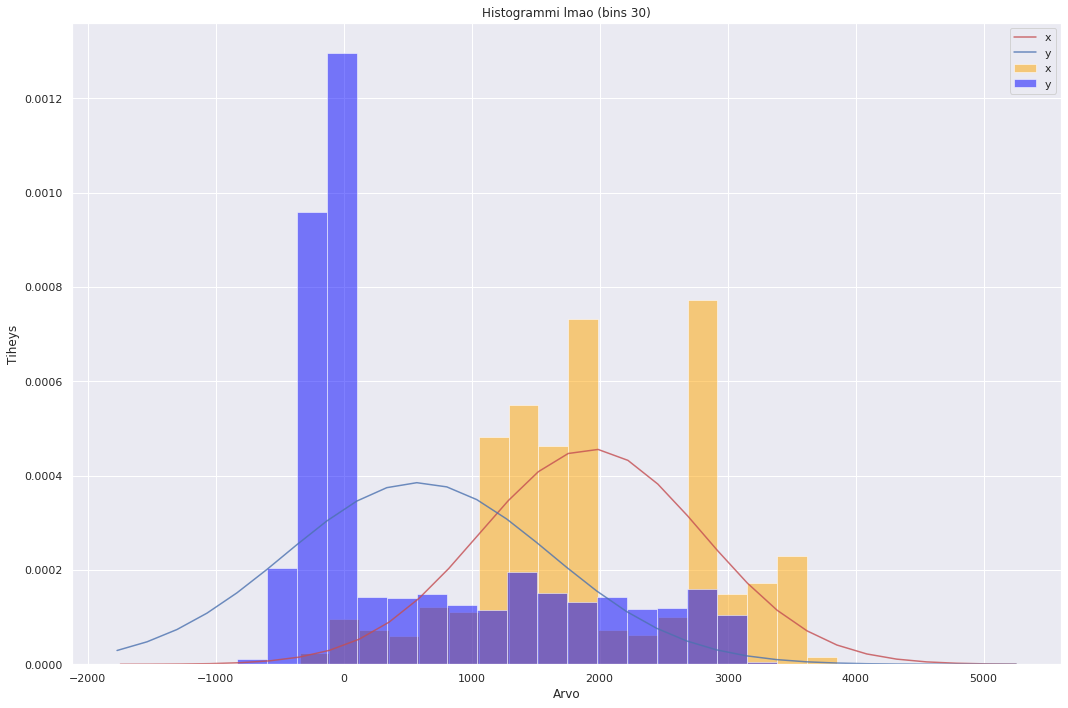

In [3]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 4041
uniques in y 4035
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  100000
Ouliers removed:     173
Data after:  99827


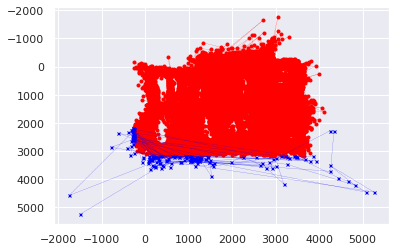

In [4]:
df1 = find_outliers(df)


# Cleaning Node_id, timestamp, q, z columns

In [5]:
df1 = clean_dataframe(df1)
df1.head(5)
df1.dtypes

node_id               int64
timestamp    datetime64[ns]
x                     int64
y                     int64
dtype: object

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

In [6]:
#for i in range(len(df1.node_id.unique())):
#    df1_node = isolation_forest(df1, 0, .003, i+1)
#    print('node numero', i+1, 'valmis')
#    
#    if i == 0:
#        df1_node.to_csv('./temp_data.csv', index=False)
#    else:
#        df1_node.to_csv('./temp_data.csv',mode='a', header=False, index=False)

In [7]:
#df1.dtypes

In [8]:
#df1 = pd.read_csv('./temp_data.csv')
#import os
#os.remove("./temp_data.csv") 
#df1.head(5)


# Poistetaan vialliset / puutteelliset nodet

In [9]:
df1 = df1[df1.node_id != 13]
df1 = df1[df1.node_id != 14]
df1 = df1[df1.node_id != 18]
df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [10]:
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,34,15,784
1,1,2020-06-24 15:20:08.620,2870,-344,35,14,735
2,1,2020-06-24 15:20:09.623,2916,-344,36,14,736
3,1,2020-06-24 15:20:09.623,2894,-254,36,15,786
4,1,2020-06-24 15:20:10.116,2888,-188,36,16,836


In [11]:
 # Otetaan kopio taulusta piirtämistä varten
#dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
#uusi_df = velocity.column_vel(df1, 'x', 'y')
# Piirtää kuvan näistä
#velocity.draw_vel(dftest, df1, 'x', 'y')

#mergedDf = df1.join(uusi_df)
#mergedDf.head()

# Write cleaned and diskretized dataframe to mariadb database

In [12]:
# Already writed, need to make update function
#write_df_to_mariadb(df1)

# Find and draw exits

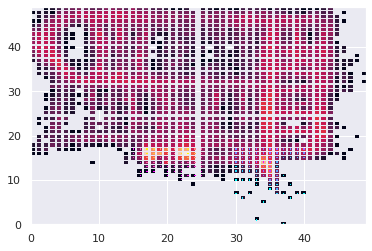

In [13]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

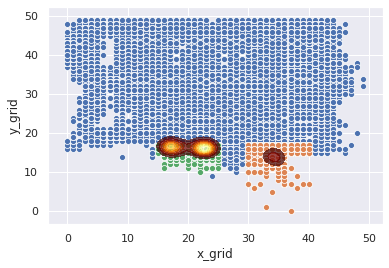

In [14]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [15]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)


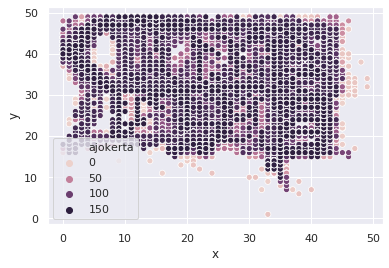

In [16]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [17]:
# Plottaa jokaisen kauppareissut erikseen.

#plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä

In [18]:
alotus, lapimeno = get_lapimeno(reitit, 50)


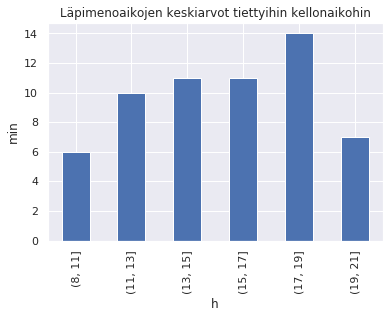

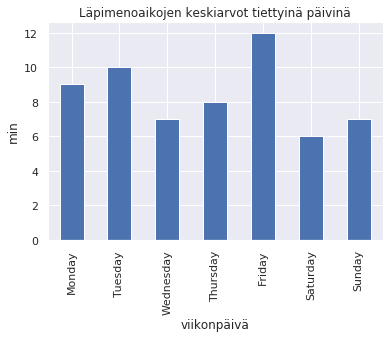

In [19]:
plot_lapimeno(alotus, lapimeno)

In [36]:
df_reitit

,ajokerta,node_id,timestamp,x,y,grid_id,kesto
0,1,2020-06-24 15:20:11.820,1,36,16,836,18:00:58.412000
1,1,2020-06-24 15:20:12.995,1,36,17,886,18:00:58.412000
2,1,2020-06-24 15:20:13.596,1,37,17,887,18:00:58.412000
3,1,2020-06-24 15:20:14.482,1,37,17,887,18:00:58.412000
4,1,2020-06-24 15:20:15.659,1,39,16,839,18:00:58.412000
...,...,...,...,...,...,...,...
71,131,2020-07-18 12:53:05.795,1,36,28,1436,00:00:46.001000
72,131,2020-07-18 12:53:05.795,1,36,28,1436,00:00:46.001000
73,131,2020-07-18 12:53:06.795,1,36,28,1436,00:00:46.001000
74,131,2020-07-18 12:53:07.795,1,37,28,1437,00:00:46.001000
